## Capstone 4: Unstrucured Learning with Recommendation System for Musical Artistis using Last.fm. 

###    Last.fm website, http://www.lastfm.com 
    @inproceedings{Cantador:RecSys2011,
      author = {Cantador, Iv\'{a}n and Brusilovsky, Peter and Kuflik, Tsvi},
      title = {2nd Workshop on Information Heterogeneity and Fusion in Recommender Systems (HetRec 2011)},
      booktitle = {Proceedings of the 5th ACM conference on Recommender systems},
      series = {RecSys 2011},
      year = {2011},
      location = {Chicago, IL, USA},
      publisher = {ACM},
      address = {New York, NY, USA},
      keywords = {information heterogeneity, information integration, recommender systems},
   } 

### Credits
   This dataset was built by Ignacio Fernández-Tobías with the collaboration of Iván Cantador and Alejandro Bellogín, 
   members of the Information Retrieval group at Universidad Autonoma de Madrid (http://ir.ii.uam.es)

   
### Contact
   Iván Cantador, ivan [dot] cantador [at] uam [dot] es

Why I chose this dataset:  
1) To stretch myself with a dataset that isn't frequently used, and where there are not a lot of recommender examples in contrast to a well known set such as MovieLens.

2) Recommender systems are frequently used in business, and they are of interest to me.  

3) This is similar to capstone 4 suggestion, "Netflix wants to identify similar movies based on movie characteristics." Rather than just output content based recommendations, members in a similar cluster or group, built collaborative and content based filters to recommend an artist based on similarities in ratings.

#### To run slideshow:

jupyter nbconvert Jupyter\ C:\Users\DJ\Documents\AnacondaPython\Thinkful\C4.ipynb --to slides --post serve

### Problem Statement:
After prepocessing data and generating a rating score, identify optimal number of clusters and make artist recommendations based on collaborative and content based clustering.

#### Clustering: cluster user ratings in three genres. 
A) K-Means  
B) Agglomorative  
C) GMM  
D) Dimension Reduction - UMAP  

#### Recommendation Systems: 
A) Collaborative recommendation - Recommend artist based on artist listening to.  
B) Collaborative recommendation - Recommend artist based on similar users.  
C) Content recommendation - Recommend artist based on genre.   

In [1]:
# HIGH LEVEL DATA PLAN

# PREPROCESSING
    # IMPORT DATA
    # BASIC EDA
    # MERGE DIFFERENT FILES INTO ONE DATAFRAME
    # CREATE RANKING SYSTEM BASED ON USER LISTENS# 
    # UNIFY TAGS BY HAVING MOST USED TAG FOR EACH ARTIST BE THE TAG FOR ARTIST

# CLUSTERING 
    # NORMALIZE
    # KMEANS
    # AGGLOMERATIVE CLUSTERING
    # GMM
    # DIMENSION REDUCTION - UMAP

# RECOMMENDER SYSTEMS, COLLABORATIVE FILTERING, CONTENT FILTERING
    #COLLABORATIVE 
        # 1) RECOMMENDATION OF ARTIST BASED ON SIMILARITY TO OTHER ARTISTS
        # 2) RECOMMENDATION OF ARTIST BASED ON SIMILARITY TO OTHER USERS
    # CONTENT BASED
        # GENRE AS CONTENT CHARACTERISTIC. RECOMMEND MOST POPULAR (HIGHEST RATED) IN GENRE

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime
import time
import os
#import re

from scipy.stats import ttest_ind

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering, KMeans

#from sklearn.preprocessing import StandardScaler, PowerTransformer # Yeo-Johnson or Boxcox
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [3]:
# OUTPUT FILES IN DIRECTORY
print(os.listdir("../Thinkful/FilesToLoad/lastfm_2k"))

['artists.dat', 'lastFM_dj.csv', 'readme.txt', 'tags.dat', 'user_artists.dat', 'user_friends.dat', 'user_taggedartists-timestamps.dat', 'user_taggedartists.dat']


In [4]:
# lOAD TAG FILE. THESE ARE TAGIDs TO TAGS (HASHTAGS) IN ANOTHER FILE
user_taggedartists=pd.read_csv('../Thinkful/FilesToLoad/lastfm_2k/user_taggedartists.dat',
                               sep='\t')

In [5]:
# LOAD USAGE OF ARTIST BY USER FILE. 
user_artists=pd.read_csv('../Thinkful/FilesToLoad/lastfm_2k/user_artists.dat', sep='\t')

In [6]:
# LOAD ARTISTID FILE
artists=pd.read_csv('../Thinkful/FilesToLoad/lastfm_2k/artists.dat', sep='\t')

In [7]:
# LOAD HASHTAG FILE, EX ROCK, POP, DINNER MUSIC, ...
tags=pd.read_csv('../Thinkful/FilesToLoad/lastfm_2k/tags.dat',encoding="ISO-8859-1", sep='\t')

In [8]:
user_taggedartists.head(5)

,userID,artistID,tagID,day,month,year
0,2,52,13,1,4,2009
1,2,52,15,1,4,2009
2,2,52,18,1,4,2009
3,2,52,21,1,4,2009
4,2,52,41,1,4,2009


In [9]:
print("\ncheck shape:\n{}".format(user_taggedartists.shape))
print("\ncheck for nulls:\n{}".format(user_taggedartists.isnull().mean()))
print("\ncheck for duplicates:\n{}".format(user_taggedartists[user_taggedartists.duplicated()].shape))

# NO NULLS OR DUPLICATES


check shape:
(186479, 6)

check for nulls:
userID      0.0
artistID    0.0
tagID       0.0
day         0.0
month       0.0
year        0.0
dtype: float64

check for duplicates:
(0, 6)


In [10]:
# CREATE PRIMARY DATAFRAME, LOAD IN DATA WILL USE
# WON'T BE USING DAY MONTH YEAR IN THIS PROJECT
df=user_taggedartists.drop(columns=['day','month','year']).copy()

In [11]:
df.head()

,userID,artistID,tagID
0,2,52,13
1,2,52,15
2,2,52,18
3,2,52,21
4,2,52,41


In [12]:
# CREATE ONE TAG FOR EACH ARTIST TO USE AS A REFERENCE POINT TO CLUSTER ON
# THE ONE TAG WILL BE BASED ON MOST FREQUENT TAG ENTERED BY USERS FOR ANY GIVEN ARTIST
# ALT AND BETTER APPROACH: FIND AN INDUSTRY STANDARD MAPPING FOR ARTIST TO MUSIC CATEGORIES

# CREATE A NEW TAG FEATURE
df['tagID_new']=0

# POPULATE GENRE ('tagValue') WITH MOST FREQUENTLY CITED FOR ARTIST
for artist_name in df['artistID'].unique():
    df_temp = df[df['artistID']==artist_name]
    max_tag = df_temp['tagID'].value_counts().idxmax()
    # df['tagValue'].value_counts().max() # FOR THE NUMBER
    #print("{} is {}".format(artist_name, max_tag))
    df.loc[(df['artistID'] == artist_name),'tagID_new'] = max_tag

In [13]:
df.head()

,userID,artistID,tagID,tagID_new
0,2,52,13,21
1,2,52,15,21
2,2,52,18,21
3,2,52,21,21
4,2,52,41,21


In [14]:
# lOOK AT NEW TAGS BY ARTIST
grouped = df.groupby(['artistID','tagID_new']).groups

cnt = 0
for artist, tag in grouped:
    cnt += 1
    if cnt < 6:
        print ("artistID: {}\ttagID_new: {}".format(artist,tag))

artistID: 1	tagID_new: 139
artistID: 2	tagID_new: 575
artistID: 3	tagID_new: 4
artistID: 4	tagID_new: 139
artistID: 5	tagID_new: 575


In [15]:
# DROP OLD tagID
df.drop(columns='tagID', axis=1, inplace=True)

In [16]:
# HAVE UNIFIED SUNDRY TAG LABELS INTO ONE LABEL PER ARTIST, THIS CREATED DUPLICATE

# CHECK FOR DUPLICATES
print("shape prior to dropping duplicates:\n {}".format(df.shape))
# SHAPE OF DUPLICATES:
print("shape of dupplicates prior to dropping duplicates:\n {}".format(df[df.duplicated()].shape))
# DROP DUPLICATES
df.drop_duplicates(keep='first', inplace=True)
# SHAPE AFTER DROPPING DUPLICATES
print("shape after dropping duplicates:\n {}".format(df.shape))
df.shape

shape prior to dropping duplicates:
 (186479, 3)
shape of dupplicates prior to dropping duplicates:
 (115415, 3)
shape after dropping duplicates:
 (71064, 3)


(71064, 3)

In [17]:
print("\ncheck shape:\n{}".format(df.shape))
print("\ncheck for nulls:\n{}".format(df.isnull().mean()))
print("\ncheck for duplicates:\n{}".format(df[df.duplicated()].shape))

# NO NULLS OR DUPLICATES


check shape:
(71064, 3)

check for nulls:
userID       0.0
artistID     0.0
tagID_new    0.0
dtype: float64

check for duplicates:
(0, 3)


In [18]:
artists.head()

,id,name,url,pictureURL
0,1,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,http://userserve-ak.last.fm/serve/252/10808.jpg
1,2,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,http://userserve-ak.last.fm/serve/252/3052066.jpg
2,3,Carpathian Forest,http://www.last.fm/music/Carpathian+Forest,http://userserve-ak.last.fm/serve/252/40222717...
3,4,Moi dix Mois,http://www.last.fm/music/Moi+dix+Mois,http://userserve-ak.last.fm/serve/252/54697835...
4,5,Bella Morte,http://www.last.fm/music/Bella+Morte,http://userserve-ak.last.fm/serve/252/14789013...


In [19]:
# PREPARE TO MERGE ARTISTS INTO df BY ESTABLISHING artistID, WILL USE TO MAP
artists.columns=['artistID','name','url','pictureURL']

In [20]:
print("\ncheck shape:\n{}".format(artists.shape))
print("\ncheck for nulls:\n{}".format(artists.isnull().mean()))
print("\ncheck for duplicates:\n{}".format(artists[artists.duplicated()].shape))
# NOT USING pictureURL, can ignore


check shape:
(17632, 4)

check for nulls:
artistID      0.000000
name          0.000000
url           0.000000
pictureURL    0.025181
dtype: float64

check for duplicates:
(0, 4)


In [21]:
# GET ARTIST NAME FIELD INTO df BY MAPPING artistID
df['name']=''
df['name'] = df['artistID'].map(artists.set_index('artistID')['name'])
df.head()

,userID,artistID,tagID_new,name
0,2,52,21,Morcheeba
5,2,63,14,Enigma
9,2,73,13,Café Del Mar
17,2,94,15,Ministry of Sound
25,2,96,192,Fleetwood Mac


In [22]:
# LOOK AT TAG IMPORT
tags.head()

,tagID,tagValue
0,1,metal
1,2,alternative metal
2,3,goth rock
3,4,black metal
4,5,death metal


In [23]:
print("\ncheck shape:\n{}".format(tags.shape))
print("\ncheck for nulls:\n{}".format(tags.isnull().mean()))
print("\ncheck for duplicates:\n{}".format(tags[tags.duplicated()].shape))

# NO NULLS OR DUPLICATES


check shape:
(11946, 2)

check for nulls:
tagID       0.0
tagValue    0.0
dtype: float64

check for duplicates:
(0, 2)


In [24]:
# MERGE tagVALUE INTO df BY MAPPING ON tagID WITH tagID_new
df['tagValue']=''
df['tagValue'] = df['tagID_new'].map(tags.set_index('tagID')['tagValue'])
# NOW HAVE NUMERIC IDS WITH ARTIST NAMES AND USER ELECTED GENRE DESIGNATION
df.head()

,userID,artistID,tagID_new,name,tagValue
0,2,52,21,Morcheeba,trip-hop
5,2,63,14,Enigma,ambient
9,2,73,13,Café Del Mar,chillout
17,2,94,15,Ministry of Sound,downtempo
25,2,96,192,Fleetwood Mac,classic rock


In [25]:
print("\ncheck shape:\n{}".format(df.shape))
print("\ncheck for nulls:\n{}".format(df.isnull().mean()))
print("\ncheck for duplicates:\n{}".format(df[df.duplicated()].shape))

# NO NULLS OR DUPLICATES


check shape:
(71064, 5)

check for nulls:
userID       0.000000
artistID     0.000000
tagID_new    0.000000
name         0.010793
tagValue     0.000000
dtype: float64

check for duplicates:
(0, 5)


In [26]:
user_artists.head()

,userID,artistID,weight
0,2,51,13883
1,2,52,11690
2,2,53,11351
3,2,54,10300
4,2,55,8983


In [27]:
print("\ncheck shape:\n{}".format(user_artists.shape))
print("\ncheck for nulls:\n{}".format(user_artists.isnull().mean()))
print("\ncheck for duplicates:\n{}".format(user_artists[user_artists.duplicated()].shape))

# NO NULLS OR DUPLICATES


check shape:
(92834, 3)

check for nulls:
userID      0.0
artistID    0.0
weight      0.0
dtype: float64

check for duplicates:
(0, 3)


In [28]:
# PREPARE TO MERGE WEIGHT (NUMBER OF LISTENING EVENTS) BY CREATING USER_ARTISTID UNIQUE ID
df['weight']=''
df['user_artistID'] = df.userID.astype(str) + '_' + df.artistID.astype(str)
user_artists['user_artistID'] = user_artists.userID.astype(str) + '_' + user_artists.artistID.astype(str)
df.head()

,userID,artistID,tagID_new,name,tagValue,weight,user_artistID
0,2,52,21,Morcheeba,trip-hop,,2_52
5,2,63,14,Enigma,ambient,,2_63
9,2,73,13,Café Del Mar,chillout,,2_73
17,2,94,15,Ministry of Sound,downtempo,,2_94
25,2,96,192,Fleetwood Mac,classic rock,,2_96


In [29]:
user_artists.tail()

,userID,artistID,weight,user_artistID
92829,2100,18726,337,2100_18726
92830,2100,18727,297,2100_18727
92831,2100,18728,281,2100_18728
92832,2100,18729,280,2100_18729
92833,2100,18730,263,2100_18730


In [30]:
# MERGE WEIGHT BASED ON MAPPING OF user_artistID combo
df['weight'] = df['user_artistID'].map(user_artists.set_index('user_artistID')['weight'])

In [31]:
df.shape

(71064, 7)

In [32]:
# CHECK FOR DUPLICATES ONCE AGAIN JUST TO BE SURE
print("duplicates: {}".format(df[df.duplicated()].shape))
#df.drop_duplicates(keep='first', inplace=True)

duplicates: (0, 7)


In [33]:
# CHECK FOR NULLS
df.isnull().mean()

userID           0.000000
artistID         0.000000
tagID_new        0.000000
name             0.010793
tagValue         0.000000
weight           0.709206
user_artistID    0.000000
dtype: float64

#### Nulls - Drop
1) Weight has nulls, very high %. This is a result of not every users having listened to every artist. Will drop these rows later.  
2) Names in artists do not match artistID resulting in nulls.

In [34]:
# DROP NULLS
df = df.dropna(axis=0, subset=['name'])
# DROP WHERE WEIGHTS ARE NULL, NO RATINGS, USER DID NOT LISTEN TO
df = df.dropna(axis=0, subset=['weight'])
# CHECK NULLS
df.isnull().mean()

userID           0.0
artistID         0.0
tagID_new        0.0
name             0.0
tagValue         0.0
weight           0.0
user_artistID    0.0
dtype: float64

In [35]:
# NUMBER OF UNIQUE GENRES BASED ON USER INPUT AND REDUCED BY UNIFYING INTO A PRIMARY TAG
df['tagValue'].nunique()

1180

In [36]:
# CREATE DATAFRAME FOR tagValue_cnt.
# THIS WILL BE USED TO GROUP VALUES AND LOOK AT POPULARITY FOR EACH TAG
df_tagValue_cnt=pd.DataFrame()
df_tagValue_cnt['tagValue']=df['tagValue']
df_tagValue_cnt['tagCnt']=1

In [37]:
# CREATE GROUP BY AND OUTPUT MOST USED TAGS
df_gb = df_tagValue_cnt.groupby(['tagValue']).sum().sort_values(ascending=False, by='tagCnt')
df_gb.head()

,tagCnt
tagValue,
pop,2316
rock,1281
indie,999
electronic,943
alternative,789


### Analysis:
Based on consumption, meaning number of listens, users have voted the top genres to be:
    pop, rock, indie, electronic, and alternative.

In [38]:
# CREATE A RANK FOR THE TAGS (GENRES) SO CAN FILTER FOR MOST FREQUENT
df_gb['tagRank']=0
counter=0
value=0
for index, row in df_gb.iterrows():
    value+=1
    df_gb['tagRank'].iloc[[counter]]=value
    counter+=1

In [39]:
df_gb['tagRank'].head(5)

tagValue
pop            1
rock           2
indie          3
electronic     4
alternative    5
Name: tagRank, dtype: int64

In [40]:
df = pd.merge(df, df_gb, how='left', on=['tagValue', 'tagValue'])

In [41]:
df.describe()

,userID,artistID,tagID_new,weight,tagCnt,tagRank
count,20665.000000,20665.000000,20665.000000,20665.000000,20665.000000,20665.000000
mean,1045.666780,3390.632906,522.422308,1425.566368,589.069973,67.035325
std,620.353435,4519.863040,1629.691027,7064.561155,713.883869,163.278196
min,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,507.000000,430.000000,25.000000,172.000000,88.000000,4.000000
50%,1029.000000,1243.000000,84.000000,411.000000,282.000000,16.000000
75%,1597.000000,4365.000000,231.000000,1014.000000,943.000000,48.000000
max,2100.000000,18744.000000,12641.000000,352698.000000,2316.000000,1180.000000


In [42]:
df.head()

,userID,artistID,tagID_new,name,tagValue,weight,user_artistID,tagCnt,tagRank
0,2,52,21,Morcheeba,trip-hop,11690.0,2_52,172,29
1,2,63,14,Enigma,ambient,3735.0,2_63,294,14
2,2,73,13,Café Del Mar,chillout,2584.0,2_73,61,61
3,2,94,15,Ministry of Sound,downtempo,1373.0,2_94,80,52
4,2,96,192,Fleetwood Mac,classic rock,1342.0,2_96,605,6


In [43]:
# BACKUP df
df_orig = df.copy()

In [44]:
# GET ALL DATA FOR JUST THE TOP 3 TAG RANKINGS INTO A DATAFRAME:  POP, ROCK, INDIE
# PURPOSE IS TO REDUCE SIZE OF FEATURES AND USERS
df = df[df['tagRank']<=3]

In [45]:
# CREATE A ZERO SUM, OR CUMULATIVE TYPE RANKING. 
# HAVE THREE GROUPS, LISTENERS HAVE LISTENED TO AT LEAST ONE
# RANK % OF LISTEN ACROSS GROUPS, WITH RESPECT TO OVERALL NUMBER OF LISTENS FOR ALL GROUPS
# INITIALIZE 0.00
df_user_genre=pd.DataFrame()
df_user_genre['userID']=df['userID'].unique()
df_user_genre['cum_weight']=0.00
df_user_genre['cum_rank']=0.00

In [46]:
# CHECK TAGS FOR A USER
user_num = 8
tags = df[df['userID']==user_num]['tagValue'].unique()
print(tags)

['pop']


In [47]:
# MAKE % FEATURE CATEGORIES SO CAN USE FOR K-MEANS CLUSTERING, DO IN df_user_genre
for i in df['tagValue'].unique(): 
    pctID = i + '_%'
    df_user_genre[pctID] = 0.00
for i in df['tagValue'].unique(): 
    df_user_genre[i]     = 0.00

In [48]:
# NORMALIZE DATA USING %
# POPULATE FIELDS WITH PERCENTAGES SO DATA IS NORMALIZED PRIOR TO KMEANS AND CLUSTERING
idx=0

for i in df['userID'].unique():
    cum_weight=0
    
    # GET UNIQUE TAGS WITHIN EACH USER
    # COUNT TAGS
    for j in df[df['userID']==i]['tagValue'].unique():
        wgt=df[(df['tagValue'] == j) & (df['userID'] == i)]['weight'].sum()
        df_user_genre.at[idx,j]= wgt
        cum_weight+=wgt
    
    df_user_genre.at[idx,'cum_weight'] = cum_weight
    
    for j in df[df['userID']==i]['tagValue'].unique():
        wgt=df[(df['tagValue'] == j) & (df['userID'] == i)]['weight'].sum()
        pct_wgt = wgt/cum_weight
        string = j + "_%"
        rank_col = string
        df_user_genre.at[idx,rank_col] = pct_wgt
    idx+=1

In [49]:
# CREATE A DATAFRAME WITH USER WHO LISTEN TO ALL THREE CATEGORIES
#df_user_genre[(df_user_genre['pop']>0) & (df_user_genre['rock']>0) & (df_user_genre['indie']>0)].count()

In [50]:
# PRIMARY DATA FRAME CONTENT AFTER PREPROCESSING
df.head()

,userID,artistID,tagID_new,name,tagValue,weight,user_artistID,tagCnt,tagRank
24,4,157,24,Michael Jackson,pop,732.0,4_157,2316,1
31,4,171,73,Stereophonics,rock,359.0,4_171,1281,2
35,4,180,24,Roxette,pop,256.0,4_180,2316,1
38,4,184,24,James Blunt,pop,247.0,4_184,2316,1
39,4,185,73,Reamonn,rock,240.0,4_185,1281,2


In [51]:
# ANOTHER SIGNIFICANT DATA FRAME WITH % RANKINGS NORMALIZED BETWEEN 0 AND 1 INCLUSIVE
# WEIGHT IS NUMBER OF LISTENING EVENTS, % IS PERCENT OF GENRE TO TOTAL
df_user_genre.head()

,userID,cum_weight,cum_rank,pop_%,rock_%,indie_%,pop,rock,indie
0,4,2031.0,0.0,0.705071,0.294929,0.0,1432.0,599.0,0.0
1,5,1022.0,0.0,0.000000,0.000000,1.0,0.0,0.0,1022.0
2,7,43864.0,0.0,1.000000,0.000000,0.0,43864.0,0.0,0.0
3,8,6693.0,0.0,1.000000,0.000000,0.0,6693.0,0.0,0.0
4,9,1149.0,0.0,0.000000,1.000000,0.0,0.0,1149.0,0.0


In [52]:
df_user_genre.isnull().mean()

userID        0.0
cum_weight    0.0
cum_rank      0.0
pop_%         0.0
rock_%        0.0
indie_%       0.0
pop           0.0
rock          0.0
indie         0.0
dtype: float64

In [53]:
#df_user_genre = df_user_genre.dropna()

In [54]:
df_user_genre['cum_rank']=df_user_genre['cum_weight']/df_user_genre['cum_weight'].sum()

### K-Means
Data prerequisites for k-means:
In order to successfully apply k-means to clustering problems, there are three prerequisites the data must meet. If you apply k-means to data that does not meet these assumptions, you will get incorrect, unintuitive results.

1. Cluster number is k K-means assumes that the correct cluster number is k. Since we provide the value of k to k-means, we need to determine the best value. However, most of the time determining k is not trivial and we need to run k-means with several k values and choose the one that makes most sense to us. 

2. Clusters are isotropic K-means assumes that the underlying "true" clusters are radially symmetrical (isotropic), meaning that they are uniform in all directions and the edges curve outward. If this assumption fails, k-means would come up with unuseful clusters. 

3. Similar variance K-means also assumes all clusters have similar variance.

The outcome of k-means can be sensitive to the scale of the data. So, standardizing each variable is a common practice before applying k-means.

The results depend on the value of k. So, choosing the correct k is essential for the algorithm to find the correct clusters. 

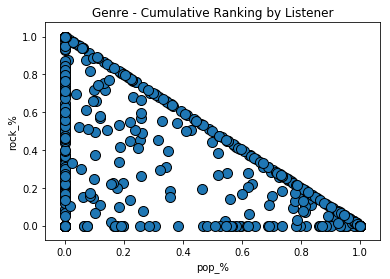

In [55]:
X = df_user_genre.loc[:,['pop_%','rock_%']].values

# VISUALIZE NORMALIZED WITH SCATTER
plt.scatter(X[:,0], X[:,1], s = 100, edgecolors='black', marker='o')
plt.title('Genre - Cumulative Ranking by Listener')
plt.xlabel('pop_%')
plt.ylabel('rock_%')
plt.show()

In [56]:
df_user_genre.shape

(1107, 9)

In [57]:
X.shape

(1107, 2)

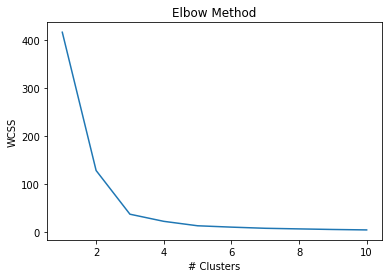

In [104]:
# OPTIMAL CLUSTER # -> ELBOW METHOD -> WITHIN CLUSTER SUM OF SQUARES (WCSS)
wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters = i, init = 'random', max_iter = 300,
                    n_init = 10, random_state = 42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,11), wcss)
plt.title('Elbow Method')
plt.xlabel('# Clusters')
plt.ylabel('WCSS')
plt.show()

# 3 CLUSTERS ARE OPTIMAL

In [59]:
pred_2 = KMeans(n_clusters=2, random_state=42).fit_predict(X)
pred_3 = KMeans(n_clusters=3, random_state=42).fit_predict(X)
pred_4 = KMeans(n_clusters=4, random_state=42).fit_predict(X)
pred_5 = KMeans(n_clusters=5, random_state=42).fit_predict(X)
pred_6 = KMeans(n_clusters=6, random_state=42).fit_predict(X)

print("Silhouette score for two   cluster k-means:\t {}".format(
    metrics.silhouette_score(X, pred_2, metric='euclidean')))
print("Silhouette score for three cluster k-means:\t {}".format(
    metrics.silhouette_score(X, pred_3, metric='euclidean')))
print("Silhouette score for four  cluster k-means:\t {}".format(
    metrics.silhouette_score(X, pred_4, metric='euclidean')))
print("Silhouette score for five  cluster k-means:\t {}".format(
    metrics.silhouette_score(X, pred_5, metric='euclidean')))

# SILHOUETTE INCREASES WITH CLUSTERS

Silhouette score for two   cluster k-means:	 0.6674554380538127
Silhouette score for three cluster k-means:	 0.7588132354576601
Silhouette score for four  cluster k-means:	 0.7594129471320296
Silhouette score for five  cluster k-means:	 0.7641331442434847


#### Agglomerative Clustering
Ward: The Ward method tends to look for spherical clusters such that the clusters are cohesive inside and differentiated from other groups. In general, this method tends to find clusters of similar size. Note that the Ward method only works with Euclidean distance.  

Complete: The Complete method links clusters using their furthest observations, that is, their most dissimilar data points. Consequently, clusters created using this method tend to be comprised of highly similar observations, making the resulting groups quite compact.  

Average: The Average method links clusters using their centroids. Since this method focuses on centroids and ignoring the boundary points, it tends to create larger groups than the complete method. Moreover, the clusters can be different sizes and shapes in contrast to the Ward method.  

In [60]:
agg_cluster1 = AgglomerativeClustering(linkage='complete', 
                                      affinity='euclidean',
                                      n_clusters=3)
clusters1 = agg_cluster1.fit_predict(X)

agg_cluster2 = AgglomerativeClustering(linkage='average', 
                                      affinity='euclidean',
                                      n_clusters=3)
clusters2 = agg_cluster2.fit_predict(X)

agg_cluster3 = AgglomerativeClustering(linkage='ward', 
                                      affinity='euclidean',
                                      n_clusters=3)
clusters3 = agg_cluster3.fit_predict(X)

agg_cluster4 = AgglomerativeClustering(linkage='complete', 
                                      affinity='manhattan',
                                      n_clusters=3)
clusters4 = agg_cluster4.fit_predict(X)

agg_cluster5 = AgglomerativeClustering(linkage='average', 
                                      affinity='manhattan',
                                      n_clusters=3)
clusters5 = agg_cluster5.fit_predict(X)

In [61]:
print("Silhoutte - metric = euclidean, linkage = complete :\t {}"
      .format(metrics.silhouette_score(X, clusters1, metric='euclidean')))

print("Silhoutte - metric = euclidean, linkage = average:\t {}"
      .format(metrics.silhouette_score(X, clusters2, metric='euclidean')))

print("Silhoutte - metric = euclidean, linkage = ward:\t\t {}"
      .format(metrics.silhouette_score(X, clusters3, metric='euclidean')))

print("Silhoutte - metric = manhattan, linkage = complete:\t {}"
      .format(metrics.silhouette_score(X, clusters4, metric='manhattan')))

print("Silhoutte - metric = manhattan, linkage = average:\t {}"
      .format(metrics.silhouette_score(X, clusters5, metric='manhattan')))

print("Silhoutte - metric = cosine, linkage = complete:\t {}"
      .format(metrics.silhouette_score(X, clusters4, metric='cosine')))

print("Silhoutte - metric = cosine, linkage = average:\t\t {}"
      .format(metrics.silhouette_score(X, clusters5, metric='cosine')))

# EUCLIDEAN BEST DISTANCE, WARD BEST LINKAGE

Silhoutte - metric = euclidean, linkage = complete :	 0.7404236065016446
Silhoutte - metric = euclidean, linkage = average:	 0.7509464111817193
Silhoutte - metric = euclidean, linkage = ward:		 0.751956918996623
Silhoutte - metric = manhattan, linkage = complete:	 0.7263976602930112
Silhoutte - metric = manhattan, linkage = average:	 0.7191474597912193
Silhoutte - metric = cosine, linkage = complete:	 0.6159459940195519
Silhoutte - metric = cosine, linkage = average:		 0.5469747916331541


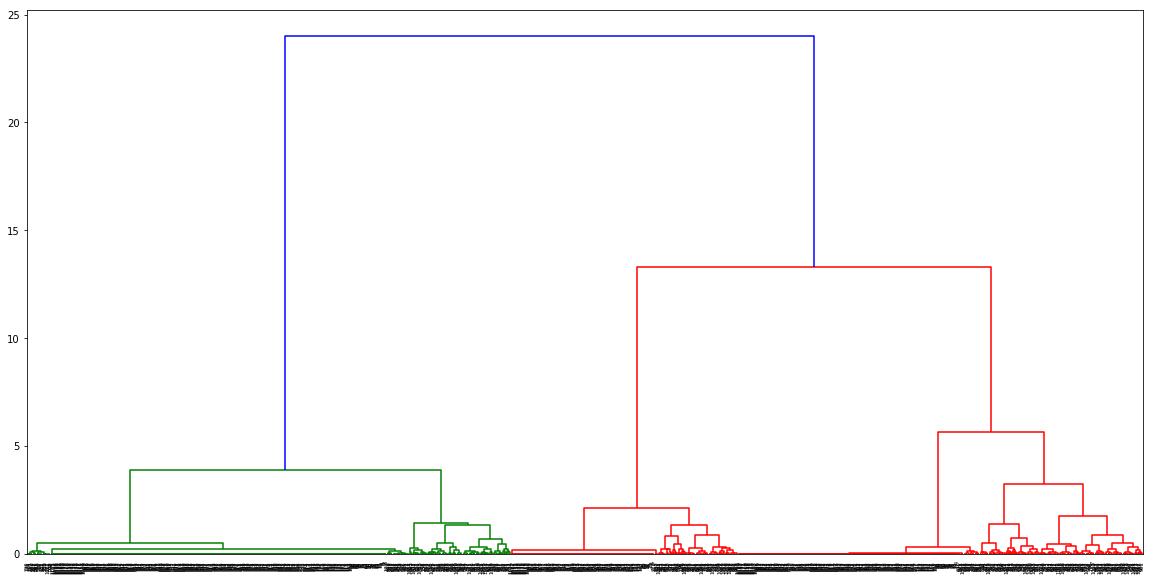

In [62]:
plt.figure(figsize=(20,10))
dendrogram(linkage(X, method='ward'))
plt.show()
# TWO CLUSTERS ARE CHOSEN, BUT THREE ARE NOTICEABLE

### GMM
There are two important assumptions that GMM makes:

The first one is that there are k distributions that generate the data. In effect, this is equivalent to say that there are exactly k clusters in the data.

The other assumption is that all of these k distributions are Gaussians. However, GMM doesn't put constraints on the parameters of these Gaussians but estimates them such that the likelihood of the data being generated by these k Gaussians is maximized.

GMM implementation of scikit-learn has a parameter called covariance_type. This parameter determines the type of covariance parameters to use. Specifically, there are four types you can specify:

full: This is the default. Each component has its own general covariance matrix.    
tied: All components share the same general covariance matrix.  
diag: Each component has its own diagonal covariance matrix.  
spherical: Each component has its own single variance.      

Full: means the components may independently adopt any position and shape.  
Tied: means they have the same shape, but the shape may be anything.  
Diagonal: means the contour axes are oriented along the coordinate axes, but otherwise the eccentricities may vary between components.  
Tied Diagonal: is a "tied" situation where the contour axes are oriented along the coordinate axes. (I have added this because initially it was how I misinterpreted "diagonal.")  
Spherical: is a "diagonal" situation with circular contours (spherical in higher dimensions, whence the name).  

In [63]:
from matplotlib.patches import Ellipse
from sklearn.mixture import GaussianMixture

gmm_cluster = GaussianMixture(n_components=3, random_state=42, covariance_type='full')
clusters = gmm_cluster.fit_predict(X)
print("Silhoutte - GMM n_components = 3, covariance_type = full:\t\t {:.3f}"
      .format(metrics.silhouette_score(X, clusters, metric='euclidean')))

gmm_cluster = GaussianMixture(n_components=3, random_state=42, covariance_type='tied')
clusters = gmm_cluster.fit_predict(X)
print("Silhoutte - GMM n_components = 3, covariance_type = tied:\t\t {:.3f}"
      .format(metrics.silhouette_score(X, clusters, metric='euclidean')))

gmm_cluster = GaussianMixture(n_components=3, random_state=42, covariance_type='diag')
clusters = gmm_cluster.fit_predict(X)
print("Silhoutte - GMM n_components = 3, covariance_type = diag:\t\t {:.3f}"
      .format(metrics.silhouette_score(X, clusters, metric='euclidean')))

gmm_cluster = GaussianMixture(n_components=3, random_state=42, covariance_type='spherical')
clusters = gmm_cluster.fit_predict(X)
print("Silhoutte - GMM n_components = 3, covariance_type = spherical:\t\t {:.3f}"
      .format(metrics.silhouette_score(X, clusters, metric='euclidean')))

gmm_cluster = GaussianMixture(n_components=4, random_state=42, covariance_type='full')
clusters = gmm_cluster.fit_predict(X)
print("Silhoutte - GMM n_components = 4, covariance_type = full:\t\t {:.3f}"
      .format(metrics.silhouette_score(X, clusters, metric='euclidean')))

gmm_cluster = GaussianMixture(n_components=4, random_state=42, covariance_type='tied')
clusters = gmm_cluster.fit_predict(X)
print("Silhoutte - GMM n_components = 4, covariance_type = tied:\t\t {:.3f}"
      .format(metrics.silhouette_score(X, clusters, metric='euclidean')))

gmm_cluster = GaussianMixture(n_components=4, random_state=42, covariance_type='diag')
clusters = gmm_cluster.fit_predict(X)
print("Silhoutte - GMM n_components = 4, covariance_type = diag:\t\t {:.3f}"
      .format(metrics.silhouette_score(X, clusters, metric='euclidean')))

gmm_cluster = GaussianMixture(n_components=4, random_state=42, covariance_type='spherical')
clusters = gmm_cluster.fit_predict(X)
print("Silhoutte - GMM n_components = 4, covariance_type = spherical:\t\t {:.3f}"
      .format(metrics.silhouette_score(X, clusters, metric='euclidean')))

# TIED (SAME SHAPE) COVARIANCE TYPE BEST PERFORMER WITH THREE COMPONENTS

Silhoutte - GMM n_components = 3, covariance_type = full:		 0.484
Silhoutte - GMM n_components = 3, covariance_type = tied:		 0.756
Silhoutte - GMM n_components = 3, covariance_type = diag:		 0.439
Silhoutte - GMM n_components = 3, covariance_type = spherical:		 0.439
Silhoutte - GMM n_components = 4, covariance_type = full:		 0.496
Silhoutte - GMM n_components = 4, covariance_type = tied:		 0.755
Silhoutte - GMM n_components = 4, covariance_type = diag:		 0.469
Silhoutte - GMM n_components = 4, covariance_type = spherical:		 0.469


#### Summary 
Three clusters are optimal.  
K-Means, the best performing clustering algorithm based on siloutette. 
K-Means, chose three clusters with the elbow method (WCSS)  
Agglomerative, Ward best performing. Chose two clusters, but three in view.  
GMM, chose three clusters, best performance came from tied covariance type (uniform shape).   

### DIMENSION REDUCTION

UMAP is fast and can handle large datasets with high-dimensional data. This is its core advantage against the t-SNE method. So, if you have a large high-dimensional data and want to visualize it, you should try UMAP first instead of t-SNE. Moreover, UMAP is usually better at preserving the global structure of the data than t-SNE. This means that it can provide a better "big picture" view of your data as well as preserving local neighbor similarities.

Hyperparameters: UMAP supports a wide variety of distance metrics, including cosine and correlation distances. Hence, the quality of the lower-dimensional representation might be affected by the metric used. We should also specify the number of neighbors and the minimum distance parameters when applying UMAP. As usual, the best way to choose values for these hyperparameters is to apply k-fold cross-validation.

Among the dimensionality reduction algorithms we cover in this module, PCA is the fastest then comes UMAP. So, if you are very time-constrained or your data isn't too complex, you should start with PCA. But if your data is complex like image, text or audio where non-linear relationship between the observations is the norm, then you should go with UMAP as it's more likely that UMAP would produce better representation of your data than PCA.

UMAP minimizes the total cross-entropy using an optimization method like Stochastic Gradient Descent (SGD). This step is an iterative one and continues until convergence.

Output does not appear to be deterministic, like t-SNE, as it changes from run to run. Cannot use in a model, for that use PCA.

In [64]:
#UNIFORM MANIFOLD APPROXIMATION AND PROJECTION
import umap
umap_results = umap.UMAP(metric='correlation').fit_transform(X)

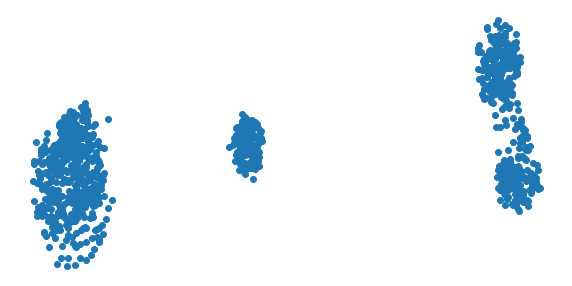

In [65]:
# UMAP DIMENSION REDUCTION USING CORRELATION
plt.figure(figsize=(10,5))
plt.scatter(umap_results[:, 0], umap_results[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()
# THREE TO FIVE CLUSTERS ARE NOTICEABLE. CHANGES WITH EACH RUN.

In [66]:
umap_results = umap.UMAP(metric='cosine').fit_transform(X)

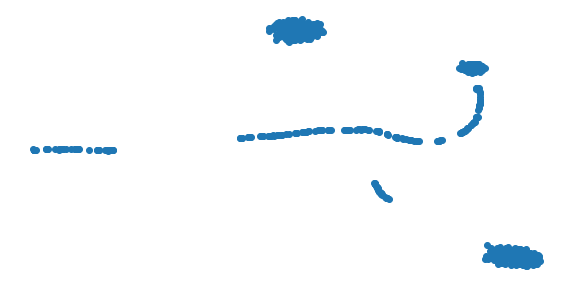

In [67]:
plt.figure(figsize=(10,5))
plt.scatter(umap_results[:, 0], umap_results[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

In [68]:
umap_results = umap.UMAP(metric='euclidean').fit_transform(X)

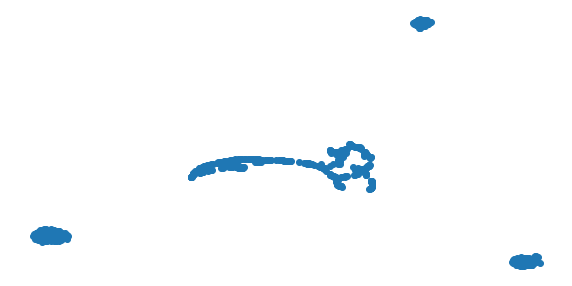

In [69]:
# UMAP DIMENSION REDUCTION USING EUCLIDEAN DISTANCE
plt.figure(figsize=(10,5))
plt.scatter(umap_results[:, 0], umap_results[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

# AT LEAST FOUR CLUSTERS ARE NOTICEABLE.

### Summary - UMAP dimension reduction
Appears to be three to four+ clusters.  
Correlation has most uniform circular output, best performer.   
Euclidean and cosine distance have linear like output.    
Correlation better than euclidean and cosine with three clusters.   
UMAP output changes with each run.  

### Summary - Clustering and dimension reduction
Three clusters appear to be the appropriate number of clusters as seen by the elbow method with K-Means and the other clustering types with the exception of possibly Agglormative. 

UMAP speaks to three to four as the optimal cluster number.  

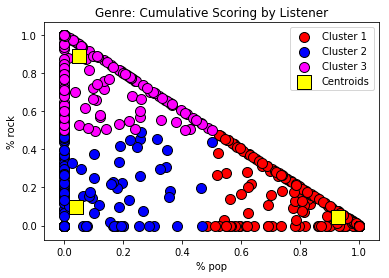

In [70]:
# CHART 3 CLUSTERS 
kmeans = KMeans(n_clusters= 3, init= 'random', max_iter=300, n_init=10,
                random_state=42)
y_kmeans = kmeans.fit_predict(X)
clusters = set(y_kmeans)
colors = ['red', 'blue', 'magenta','grey']
labels = ['Cluster {}'.format(i+1) for i in set(y_kmeans)]
for clust, color, labels in zip(clusters, colors, labels):
    plt.scatter(X[y_kmeans == clust, 0], X[y_kmeans == clust, 1], 
                s=100, c = color, label = labels, edgecolors='black')
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], s = 200, c = 'yellow', 
            label = 'Centroids', edgecolors='black', marker='s')
plt.title('Genre: Cumulative Scoring by Listener')
plt.xlabel('% pop')
plt.ylabel('% rock')
plt.legend()
plt.show()

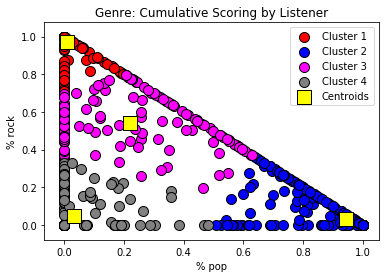

In [71]:
# CHART 4 CLUSTERS 
kmeans = KMeans(n_clusters= 4, init= 'random', max_iter=300, n_init=10,
                random_state=42)
y_kmeans = kmeans.fit_predict(X)
clusters = set(y_kmeans)
colors = ['red', 'blue', 'magenta','grey']
labels = ['Cluster {}'.format(i+1) for i in set(y_kmeans)]
for clust, color, labels in zip(clusters, colors, labels):
    plt.scatter(X[y_kmeans == clust, 0], X[y_kmeans == clust, 1], 
                s=100, c = color, label = labels, edgecolors='black')
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], s = 200, c = 'yellow', 
            label = 'Centroids', edgecolors='black', marker='s')
plt.title('Genre: Cumulative Scoring by Listener')
plt.xlabel('% pop')
plt.ylabel('% rock')
plt.legend()
plt.show()

In [72]:
# FIT KMEANS ALGORITHM
kmeans = KMeans(n_clusters=3).fit(X)
preds = kmeans.predict(X)

# GET CENTROIDS
centroids = kmeans.cluster_centers_

In [73]:
# DISTANCE FROM CENTROID

from scipy.spatial import distance_matrix

dist_mat = pd.DataFrame(distance_matrix(X, centroids))
dist_mat.groupby(preds).mean()

,0,1,2
0,0.129049,1.217391,0.895465
1,1.219562,0.168218,0.800675
2,0.901120,0.796770,0.153209


In [74]:
cluster_map = pd.DataFrame()
cluster_map['data_index'] = df_user_genre.index.values
cluster_map['cl_label'] = kmeans.labels_

In [75]:
df_user_genre= pd.concat([df_user_genre, cluster_map['cl_label']], axis=1)
df_user_genre= pd.concat([df_user_genre, dist_mat], axis=1)
df_user_genre.head()

,userID,cum_weight,cum_rank,pop_%,rock_%,indie_%,pop,rock,indie,cl_label,0,1,2
0,4,2031.0,0.000194,0.705071,0.294929,0.0,1432.0,599.0,0.0,0,0.333555,0.883377,0.692008
1,5,1022.0,0.000098,0.000000,0.000000,1.0,0.0,0.0,1022.0,2,0.928789,0.889786,0.106906
2,7,43864.0,0.004187,1.000000,0.000000,0.0,43864.0,0.0,0.0,0,0.086012,1.300131,0.963525
3,8,6693.0,0.000639,1.000000,0.000000,0.0,6693.0,0.0,0.0,0,0.086012,1.300131,0.963525
4,9,1149.0,0.000110,0.000000,1.000000,0.0,0.0,1149.0,0.0,1,1.330300,0.122626,0.902444


In [76]:
df.head()

,userID,artistID,tagID_new,name,tagValue,weight,user_artistID,tagCnt,tagRank
24,4,157,24,Michael Jackson,pop,732.0,4_157,2316,1
31,4,171,73,Stereophonics,rock,359.0,4_171,1281,2
35,4,180,24,Roxette,pop,256.0,4_180,2316,1
38,4,184,24,James Blunt,pop,247.0,4_184,2316,1
39,4,185,73,Reamonn,rock,240.0,4_185,1281,2


## START BASIC RECOMMENDER

### COLLABORATIVE FILTER - ARTIST 

In [77]:
# INPUT THE CLUSTER OF INTEREST
cluster_of_interest = 2

In [78]:
from scipy.spatial.distance import cosine, euclidean, correlation

In [79]:
#GET CLUSTER NUMBER INTO df SO CAN LIMIT INPUTS INTO RECOMMENDATION ENGINES
df['cl_label'] = df['userID'].map(df_user_genre.set_index('userID')['cl_label'])

In [80]:
# USE COPY SO WON'T IMPACT WEIGHTS IN df 
df_preprocess = df[df['cl_label']==cluster_of_interest][['userID','name','weight']].copy()
df_preprocess['weight']=1
df_preprocess.head()

,userID,name,weight
45,5,Keane,1
47,5,Bright Eyes,1
56,5,Clap Your Hands Say Yeah,1
97,10,Arcade Fire,1
99,10,Death Cab for Cutie,1


In [81]:
# COUNT AGGREGATION COLUMN BASED ON ARTISTID
df_preprocess['count'] = df_preprocess.groupby('name')['name'].transform('count')

# ARTIST REQUIRES >=2 EVENTS TO BE CONSIDERED
df_preprocess = df_preprocess[(df_preprocess['count']>=2)]

# OUTPUT UNIQUE ARTISTS SO VALIDATE NO DUPES WHEN PIVOT
df_preprocess['name'].nunique()

145

In [82]:
df_preprocess=df_preprocess.pivot(index='userID', columns='name', values='weight')
df_preprocess=df_preprocess.reset_index()
df_preprocess.shape

(232, 146)

In [83]:
df_preprocess.shape

(232, 146)

In [84]:
df_same_clust=df_preprocess.copy()
df_same_clust.rename(columns={'userID':'user'}, inplace=True)

In [85]:
df_same_clust.fillna(0,inplace=True)

In [86]:
df_same_clust.head()

name,user,3 Doors Down,30 Seconds to Mars,ABBA,Air Traffic,Arcade Fire,Ashlee Simpson,Audioslave,Avril Lavigne,Babasónicos,...,Vampire Weekend,We Are Scientists,Weezer,Wilco,Wolfmother,Xiu Xiu,Yo La Tengo,Zoé,of Montreal,Мои Ракеты Вверх
0,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,10,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,38,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [87]:
# ARTISTS AS FEATURES, INDEX  
df_same_clust_no_user = df_same_clust.drop('user', 1)
 
# Create a placeholder dataframe listing item vs. item
df_item_sim_scr = pd.DataFrame(index=df_same_clust_no_user.columns,columns=
                         df_same_clust_no_user.columns)

In [88]:
# ITEM BASED SIMILARITY - USE EUCLIDEAN TO MEASURE DISTANCE AND POPULATE

# USE COSINE FOR SIMILARITY SCORE
# LOOP COLUMNS
for i in range(0,len(df_item_sim_scr.columns)):
    for j in range(0,len(df_item_sim_scr.columns)):
        # SIMILARITY SCORE
        # COSINE 
        #df_item_sim_scr.iloc[i,j] = 1-cosine(df_same_clust_no_user.iloc[:,i],
        #                                     df_same_clust_no_user.iloc[:,j])
        # CORRELATION
        #df_item_sim_scr.iloc[i,j] = 1-correlation(df_same_clust_no_user.iloc[:,i],
        #                                        df_same_clust_no_user.iloc[:,j])
        # EUCLIDEAN
        df_item_sim_scr.iloc[i,j] = 1-euclidean(df_same_clust_no_user.iloc[:,i],
                                                 df_same_clust_no_user.iloc[:,j])

In [89]:
# SIMILARITY MATRIX BASED ON EUCLIDEAN DISTANCE
# CHOSE EUCLIDEAN BECAUSE BEST PERFORMING CLUSTERING ALGORITHIMS BASED ON EUCLIDEAN
df_item_sim_scr.head()

name,3 Doors Down,30 Seconds to Mars,ABBA,Air Traffic,Arcade Fire,Ashlee Simpson,Audioslave,Avril Lavigne,Babasónicos,Band of Horses,...,Vampire Weekend,We Are Scientists,Weezer,Wilco,Wolfmother,Xiu Xiu,Yo La Tengo,Zoé,of Montreal,Мои Ракеты Вверх
name,,,,,,,,,,,,,,,,,,,,,
3 Doors Down,1,-1.64575,-1,-1,-4.19615,-1,-0.414214,-1.44949,-1,-2,...,-2.31662,-1.23607,-1.82843,-1.23607,-1,-1,-1.23607,-1.44949,-2.4641,-1.23607
30 Seconds to Mars,-1.64575,1,-1.64575,-1.64575,-4.2915,-1.64575,-1.64575,-2,-1.64575,-2.4641,...,-2.74166,-1.82843,-2.31662,-1.82843,-1.64575,-1.64575,-1.82843,-2,-2.87298,-1.82843
ABBA,-1,-1.64575,1,-1,-4.19615,-1,-1,-1.44949,-1,-2,...,-2.31662,-1.23607,-1.82843,-1.23607,-1,-1,-1.23607,-1.44949,-2.4641,-1.23607
Air Traffic,-1,-1.64575,-1,1,-4.19615,-1,-1,-1.44949,-1,-2,...,-2.31662,-1.23607,-1.82843,-1.23607,-1,-1,-1.23607,-1.44949,-2.4641,-1.23607
Arcade Fire,-4.19615,-4.2915,-4.19615,-4.19615,1,-4.19615,-4.19615,-4.38516,-4.19615,-4.65685,...,-4.65685,-4.09902,-4.19615,-3.89898,-4,-4,-4.2915,-4.38516,-4.56776,-4.2915


In [90]:
# SORT QC - MAKE SURE VALUES ARE
df_item_sim_scr.iloc[0:,3].sort_values(ascending=False)[:6]

name
Air Traffic            1
Orson          -0.414214
The Subways    -0.414214
Tahiti 80      -0.414214
The Wombats    -0.732051
3 Doors Down          -1
Name: Air Traffic, dtype: object

In [91]:
# CLOSEST SIMILARITY FOR ITEM
df_item_sim = pd.DataFrame(index=df_item_sim_scr.columns,columns=range(1,11))

In [92]:
df_item_sim.head()

,1,2,3,4,5,6,7,8,9,10
name,,,,,,,,,,
3 Doors Down,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30 Seconds to Mars,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ABBA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Air Traffic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Arcade Fire,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [93]:
# LOOP ITEM BASED SIMILARITY AND POPULATE NAMES ASSOCIATED WITH HIGHEST SIM SCORE 
for i in range(0,len(df_item_sim_scr.columns)):
    df_item_sim.iloc[i,:10] = df_item_sim_scr.iloc[0:,i].sort_values(
        ascending=False)[:10].index

In [94]:
# SIMILAR ARTISTS BASED AS COMPARED TO CURRENT ARTIST LISTENING TO
df_item_sim.iloc[:5,1:5]

,2,3,4,5
name,,,,
3 Doors Down,Audioslave,The Perishers,Peter Bjorn and John,The All-American Rejects
30 Seconds to Mars,Linkin Park,Julian Casablancas,Evanescence,My Chemical Romance
ABBA,George Michael,Mika,HIM,Garbage
Air Traffic,Orson,The Subways,Tahiti 80,The Wombats
Arcade Fire,Spoon,The New Pornographers,Grizzly Bear,Wilco


### COLLABORATIVE FILTER - USER 

In [95]:
# RECOMMEND BASED ON SIMILAR USER LISTENING HABITS
# RETURN SIMILAR USER AND THEIR PREFERENCES

# FUNCTION FOR SIMILARITY SCORES
def getScore(history, similarities):
   return sum(history*similarities)/sum(similarities)

In [96]:
# CREATE DATAFRAME FOR USER SIMILIARITY SCORE
# FILL IN THE USER NAME COLUMN ??? CHECK THIS
data_sims1 = pd.DataFrame(index=df_same_clust.index,columns=df_same_clust.columns)
data_sims1.iloc[:,:1] = df_same_clust.iloc[:,:1]

In [97]:
#Loop through all rows, skip the user column, and fill with similarity scores
for i in range(0,len(data_sims1.index)):
    for j in range(1,len(data_sims1.columns)):
        user1 = data_sims1.index[i]
        product1 = data_sims1.columns[j]
        #print(product1)
 
        if df_same_clust.iloc[i][j] == 1:
            data_sims1.iloc[i][j] = 0
        else:
            product_top_names1 = df_item_sim.loc[product1][1:10]
            product_top_sims1 = df_item_sim_scr.loc[product1].sort_values(ascending=False)[1:10]
            user_purchases1 = df_same_clust_no_user.loc[user1,product_top_names1]
            data_sims1.iloc[i][j] = getScore(user_purchases1,product_top_sims1)

In [98]:
# GET TOP ARTISTS
data_recommend1 = pd.DataFrame(index=data_sims1.index, columns=['user','1','2','3','4','5','6'])
data_recommend1.iloc[0:,0] = data_sims1.iloc[:,0]

In [99]:
# POPULATE DATAFRAME WITH ARTIST
for i in range(0,len(data_sims1.index)):
    data_recommend1.iloc[i,1:] = data_sims1.iloc[i,:].sort_values(ascending=False).iloc[1:7,].index.transpose()

In [100]:
data_recommend1.head(2)

,user,1,2,3,4,5,6
0,5,Broken Social Scene,Final Fantasy,Interpol,Yo La Tengo,Pavement,Myslovitz
1,10,Faith No More,Jet,Interpol,Incubus,Imogen Heap,HIM


In [101]:
# GIVE RECOMMENDATIONS FOR SIMILAR USERS
# CAN FROM HERE IDENTIFY ARTISTS THAT SIMILAR USERS LIKE, BUT CURRENT USER HASN'T LISTENED TO
data_recommend1.iloc[0:10,:5]

,user,1,2,3,4
0,5,Broken Social Scene,Final Fantasy,Interpol,Yo La Tengo
1,10,Faith No More,Jet,Interpol,Incubus
2,27,Faith No More,Jet,Interpol,Incubus
3,38,Faith No More,Jet,Interpol,Incubus
4,50,Faith No More,Jet,Interpol,Incubus
5,62,Garbage,Faith No More,The Veronicas,Paramore
6,73,The All-American Rejects,Foals,The Kooks,Florence + the Machine
7,77,Faith No More,Jet,Interpol,Incubus
8,88,Bloc Party,Good Shoes,Jet,Interpol
9,97,Two Door Cinema Club,George Michael,Interpol,Incubus


### CONTENT BASED - VERY BASIC, USE TAG INPUT FOR MOST POPULAR IN GENRE

In [102]:
# CONTENT BASED FILTER
# INPUT TAG (CONTENT), EITHER ROCK, POP OR INDIE, GET TOP FIVE MOST LISTENED TO ARTISTS
#tag_of_interest = 'indie'
#tag_of_interest = 'rock'
tag_of_interest = 'pop'
df[df['tagValue']==tag_of_interest].groupby('name')['weight'].sum().sort_values(ascending=False).head()

name
Britney Spears        1664992.0
Christina Aguilera     677708.0
Lady Gaga              564453.0
Shakira                474315.0
Madonna                432089.0
Name: weight, dtype: float64

### CONTENT BASED - VERY BASIC, PROXIMITY TO CENTROID OF CLUSTERS BASED ON GENRE RANKS

In [103]:
# CONTENT BASED FILTER
# GET FIVE USERS CLOSEST TO CENTROID IN A CLUSTER
# INPUT CLUSTER NUMBER
cluster_num = 1
df_user_genre.sort_values(by=[cluster_num], ascending=True).head()
#top5['userID']

,userID,cum_weight,cum_rank,pop_%,rock_%,indie_%,pop,rock,indie,cl_label,0,1,2
230,430,10125.0,0.000966,0.073383,0.875556,0.051062,743.0,8865.0,517.0,1,1.190422,0.026048,0.777697
467,904,3300.0,0.000315,0.012727,0.877879,0.109394,42.0,2897.0,361.0,1,1.236232,0.039377,0.779899
110,203,800.0,0.000076,0.083750,0.916250,0.000000,67.0,733.0,0.0,1,1.211872,0.043266,0.818828
294,545,26408.0,0.002521,0.097736,0.888632,0.013632,2581.0,23467.0,360.0,1,1.182347,0.047048,0.792117
205,388,26909.0,0.002568,0.061764,0.938236,0.000000,1662.0,25247.0,0.0,1,1.242962,0.051110,0.839968


### SUMMARY
#### Q: A specified research question your model addresses.  
>What are the optimal number of clusters given genre inputs? This analysis identifies three as the optimal number of clusters when comparing rock vs pop genres. Meaning users either:  
>1) really like rock and not really pop  
>2) at best sort of likes rock, at best sort of likes pop  
>3) really like pop, but not really rock  

#### Q: How you chose your model specification and what alternatives you compared it to.  
>Chose K-Means based on WCSS, the elbow method. 
Used sillouette scores for other clustering algorithms, including GMM and Agglomerative Clustering.  

#### Q: Quantifiable results based on the research you’ve conducted.  
>Results favored euclidean distance in siloutette scores.   
Siloutette scores kept going up with cluster number.   
Elbow method rate of change appears to have decreased at three and started to blatten at 4.  

#### Q: The visuals you chose and what they represent for your research.  
> Chose cluster visuals for unstructured data exploration and rational behind cluster choice.  
> Chose similarity matrix and output for recommedation engine to show inner workings and end result.  

#### Your end-user and the value your project provides to them.  
>End user is both the corporation implementing the algorithm and the user using the service. By provideing a quality recommendation, this improves overall experience for the user, as well as customer retention for the company. Company benefits from clustering by better understanding the user. Could be used to understand how to advertise, cross market opportunities for artists and many more.  

#### The practical uses of your model for an audience of interest.  
> Find new artists haven't listened to before that are relevant and interesting.  
> Break apart groupings of users to better understand how behavior is broken down outside of traditional labels.  

#### Potential problems or bias, any weak points or shortcomings of your model.  
> Selection bias. Model uses user tags. Not all users enter tags.   
> Classification, users don't have a structured approach to tagging.   
> Weights based on user listening preferences may overlook artists the user likes, but doesn't listen to on the platform for whatever reason.   
> Approach is simplistic, and not nuanced.   

#### Additional research proposal  
>Compare to KNN recommendation system.  
Explore how to rate the performance of recommendation.  
Explore appropriate distance metrics for clustering this type of data.
Change rank from cumulative to decile rank based on user weighting.
Scale, so can perform analysis using all genres.